# Sport Classification Example

In [ ]:
!pip install --upgrade transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.10.1
    Uninstalling huggingface-hub-0.10.1:
      Successfully uninstalled huggingface-hub-0.10.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cached-path 1.1.6 requires huggingface-hub<0.11.0,>=0.8.1, but you have huggingface-hub 0.12.1 which is incompatible.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.26.1 which is incompatible.


https://github.com/PatrickHua/EasyImageNet - от сюда взял туториал как скачать imagenet

In [ ]:
!yes| apt-get install transmission-cli transmission-common transmission-daemon
!service transmission-daemon start

# скачиваю только валидационную часть
!transmission-remote -n 'transmission:transmission' -a http://academictorrents.com/download/5d6d0df7ed81efd49ca99ea4737e0ae5e3a5f2e5.torrent

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libminiupnpc17 libnatpmp1
Suggested packages:
  minissdpd natpmpc transmission-gtk
The following NEW packages will be installed:
  libminiupnpc17 libnatpmp1 transmission-cli transmission-common
  transmission-daemon
0 upgraded, 5 newly installed, 0 to remove and 132 not upgraded.
Need to get 901 kB of archives.
After this operation, 4272 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 transmission-common all 2.94-2ubuntu3 [237 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libminiupnpc17 amd64 2.1.20190824-0ubuntu2 [25.8 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libnatpmp1 amd64 20150609-7build1 [7724 B]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 transmission-daemon amd64 2.94-2ubuntu3 [222 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal/un

In [ ]:
# отслеживать прогресс скачивания
!transmission-remote -n 'transmission:transmission' -l or watch -n 1 "transmission-remote -n 'transmission:transmission' -l"

ID     Done       Have  ETA           Up    Down  Ratio  Status       Name
   1   100%    6.74 GB  Done         0.0     0.0    0.0  Idle         ILSVRC2012_img_val.tar
Sum:           6.74 GB               0.0     0.0
Unknown option: or
Unknown option: watch
Unknown option: transmission-remote -n 'transmission:transmission' -l


In [ ]:
!service transmission-daemon stop

 * Stopping bittorrent daemon transmission-daemon
   ...done.


In [ ]:
!mkdir tmp && mv /var/lib/transmission-daemon/downloads/ILSVRC2012_img_val.tar tmp/

In [ ]:
!ls tmp

In [ ]:
! cd tmp && tar xvf ILSVRC2012_img_val.tar && rm -f ILSVRC2012_img_val.tar

In [ ]:
# !ls tmp

CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8

In [ ]:
%env CUBLAS_WORKSPACE_CONFIG=:4096:8 

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


In [ ]:
import os
import sys
import math
import logging
import random
import torch
import shutil
import torch.nn as nn
import transformers
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from typing import List, Dict, Tuple, Any
from tqdm.notebook import tqdm
from transformers import BeitForImageClassification, BeitImageProcessor



plt.style.use('dark_background')
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.use_deterministic_algorithms(True)



def init_logger() -> logging.RootLogger:
    global logger
    logger.handlers.clear()
    logger = logging.getLogger()
    streamHandler = logging.StreamHandler(sys.stdout)
    fileHandler = logging.FileHandler("logfile.log")
    strfmt = "[%(asctime)s] [%(name)s] [%(levelname)s] > %(message)s"
    datefmt = "%Y-%m-%d %H:%M"
    formatter = logging.Formatter(fmt=strfmt, datefmt=datefmt)
    streamHandler.setFormatter(formatter)
    fileHandler.setFormatter(formatter)
    logger.addHandler(streamHandler)
    logger.addHandler(fileHandler)
    return logger



def init_metrics() -> Dict[str, Dict[str, List[float]]]:
    metrics = {
        "train": {
            "loss": [],
            "f1_score": [],
        },
        "valid": {
            "loss": [],
            "f1_score": [],
        }
    }
    return metrics



def move_images(
    images : List[str],
    old_dir: str,
    new_dir: str,   
) -> None:
    
    for image in tqdm(images):
        old_path = Path(old_dir, image)
        new_path = Path(new_dir, image)
        shutil.copyfile(old_path, new_path)
    

# Plots

In [ ]:
def plot_massive_by_label(
    df          : pd.DataFrame, 
    label       : str, 
    size        : int, 
    folder_path : str,
    random_state: int=SEED, 
    n_columns   : int=5,
) -> None: 
    if size > 40:
        size = 40
        
    np.random.seed(random_state) 
    path = Path(folder_path)
    mask = df["label"].values == label
    df = df.iloc[mask, :] 
    idx = np.random.choice(df.index, size, replace=False)
    df = df.loc[idx]
    fig, ax = plt.subplots(math.ceil(size / n_columns), n_columns)
    fig.set_size_inches(20, 20)
    fig.suptitle(label, fontsize = 18)
    for i, index in enumerate(idx):
        row = df.loc[index]
        label, pos = row.image_id, row.label,
        img = Image.open(path / label)
        x, y = divmod(i, n_columns)
        ax[x, y].imshow(img)
        ax[x, y].set_title(index)
        
        
        
def plot_cross_probabilities(
    df         : pd.DataFrame,
    folder_path: str="train",
    n_columns  : int=5,
) -> None:
    
    size = len(df)
    if size > 20:
        size = 20
        df = df.iloc[:20, :] 
        
    path = Path(folder_path)
    fig, ax = plt.subplots(math.ceil(size / n_columns), n_columns)
    fig.set_size_inches(20, 20)
    for i, index in enumerate(df.index): 
        row = df.loc[index]
        label, pos = row.image_id, row.label
        img = Image.open(path / label)
        x, y = divmod(i, n_columns)
        ax[x, y].imshow(img)
        true_label = row.label
        pred_label = row.pred_label
        true_prob = row.true_proba
        max_prob = row.max_proba
        imagenet_proba = row.imagenet_proba
        title = f"true_label: {true_label} p={true_prob:.3f} \n \
            pred_label: {pred_label} p={max_prob:.3f} \n \
            imagenet_proba: {imagenet_proba:.3f}"
        ax[x, y].set_title(title)   

# Datasets 

SportDataset - датасет расчета ембединго или для использвания "end-to-enc" моделью

EmbeddingsDataset -  датасет ембедингов

In [ ]:
class SportDataset(Dataset):
    def __init__(
        self, 
        df        : pd.DataFrame,
        img_path  : str,
        processor : transformers.models.beit.image_processing_beit.BeitImageProcessor,
        augmenter : torchvision.transforms.transforms.Compose=None,
        mode      : str="train"
    ):
        super().__init__()
        self.data_path = Path(img_path)
        self.processor = processor
        self.augmenter = augmenter
        if mode == "train":
            self.samples = list(zip(df["image_id"], df["digital_label"]))
        else:
            self.samples = list(zip(df["image_id"], np.zeros_like(df["image_id"])))
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        image_id, label = self.samples[index]
        image = Image.open(self.data_path / image_id).convert('RGB')
        if self.augmenter:
            image = self.augmenter(image)
        image = self.processor(image, return_tensors="pt")            
        return image["pixel_values"][0], label
    
    def __len__(self):
        return len(self.samples)
    

    
class EmbeddingsDataset(Dataset):
    def __init__(self, embs: np.array, labels: np.array):
        super().__init__()
        self.embs = embs.astype(np.float32)
        self.labels = labels.astype(np.int64)
    
    def __getitem__(self, index: int) -> Tuple[np.array, int]:
        return self.embs[index], self.labels[index]
    
    def __len__(self) -> int:
        return len(self.labels)

# Модель

## Pretrained modules (Beit > Vit)

Large

In [ ]:
model_cfg = "microsoft/beit-large-patch16-224-pt22k-ft22k"
beit = BeitForImageClassification.from_pretrained(model_cfg).beit

embeddings = beit.embeddings
encoder = beit.encoder
pooler = beit.pooler
transforms = BeitImageProcessor.from_pretrained(model_cfg)

logger = logging.getLogger()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  

Base

In [ ]:
# cfg = "microsoft/beit-large-patch16-224-pt22k-ft22k"
# beit = BeitForImageClassification.from_pretrained(cfg).beit

# embeddings = beit.embeddings
# encoder = beit.encoder
# pooler = beit.pooler
# transforms = BeitImageProcessor.from_pretrained(cfg)

# logger = logging.getLogger()
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  

In [ ]:
class Classifier(nn.Module):
    
    def __init__(self, emb_size = 1024, dropout = 0.4, n_class=30):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(emb_size, emb_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(emb_size, n_class) 
        )
        
        nn.init.orthogonal_(self.classifier[1].weight)
        nn.init.orthogonal_(self.classifier[4].weight)
        self.device = torch.device("cpu") 
        
    def forward(self, input):
        return self.classifier(input)
        
    def to(self, *args, **kwargs):
        device, dtype, non_blocking, convert_to_format = torch._C._nn._parse_to(*args, **kwargs)
        self.device = device

        def convert(t):
            if convert_to_format is not None and t.dim() in (4, 5):
                return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None,
                            non_blocking, memory_format=convert_to_format)
            return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)

        return self._apply(convert)

  
    
class Model(nn.Module):
    
    def __init__(
        self,
        embeddings: transformers.models.beit.modeling_beit.BeitEmbeddings,
        encoder:    transformers.models.beit.modeling_beit.BeitEncoder,
        pooler:     transformers.models.beit.modeling_beit.BeitPooler,
        classifier: Classifier=None,
    ):
        super(Model, self).__init__()
        self.embeddings = embeddings
        self.encoder = encoder
        self.pooler = pooler
        self.classifier = classifier
        self.device = torch.device("cpu") 

    def forward(self, x):
        x = self.embeddings(x)
        x = self.encoder(x).last_hidden_state
        x = self.pooler(x)
        if self.classifier:
            x = self.classifier(x)
        return x
    
    def to(self, *args, **kwargs):
        device, dtype, non_blocking, convert_to_format = torch._C._nn._parse_to(*args, **kwargs)
        self.device = device

        def convert(t):
            if convert_to_format is not None and t.dim() in (4, 5):
                return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None,
                            non_blocking, memory_format=convert_to_format)
            return t.to(device, dtype if t.is_floating_point() or t.is_complex() else None, non_blocking)

        return self._apply(convert)

# Utils

In [ ]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm



def trainer(
    model,
    dataloader: torch.utils.data.dataloader.DataLoader,
    optimizer : torch.optim,
    criterion : torch.nn.modules.loss.CrossEntropyLoss,
    metrics   : Dict[str, Dict[str, List[float]]],
) -> None:
    
    model.train()
    device = model.device
    y_true, y_pred, losses = [], [], []
    accumulate_loss = 0.0
    for X, y in dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        y_true += y.cpu().tolist()
        y_pred += logits.argmax(axis=1).tolist() 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1 = f1_score(y_pred, y_true, average="micro")
    losses = np.array(losses)
    mean_loss = losses.mean()
    metrics["train"]["loss"].append(mean_loss)
    metrics["train"]["f1_score"].append(f1)



@torch.no_grad()
def evaluate(
    model,
    dataloader: torch.utils.data.dataloader.DataLoader,
    criterion : torch.nn.modules.loss.CrossEntropyLoss,
    metrics   : Dict[str, Dict[str, List[float]]],
    
) -> None:
    
    model.eval()
    device = model.device
    y_true, y_pred, losses = [], [], []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits, y)
        losses.append(loss.item())
        y_true += y.cpu().tolist()
        y_pred += logits.argmax(axis=1).tolist() 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    f1 = f1_score(y_pred, y_true, average="micro")
    losses = np.array(losses)
    mean_loss = losses.mean()
    metrics["valid"]["loss"].append(mean_loss)
    metrics["valid"]["f1_score"].append(f1)



def train_loop(
    model,
    train_loader: torch.utils.data.dataloader.DataLoader,
    valid_loader: torch.utils.data.dataloader.DataLoader,
    criterion   : torch.nn.modules.loss.CrossEntropyLoss, 
    optimizer   : torch.optim, 
    n_epoch     : int,
    metrics     : Dict[str, Dict[str, List[float]]], 
    logger      : logging.RootLogger = None,
    step_logger : int = 1,
    verbose     : bool=True,
) -> None:
    
    for i in tqdm(range(n_epoch)):     
        if verbose:
            train_pbar = tqdm(iter(train_loader), leave=True, total=len(train_loader))
            trainer(model, train_pbar, optimizer, criterion, metrics)
            valid_pbar = tqdm(iter(valid_loader), leave=True, total=len(valid_loader))
            evaluate(model, valid_pbar, criterion, metrics)
        else:
            trainer(model, train_loader, optimizer, criterion, metrics)
            evaluate(model, valid_loader, criterion, metrics)
        
        if logger and (i % step_logger == 0 or n_epoch == i + 1):
            epoch = len(metrics["train"]["loss"])
            logger.info(f"epoch: {epoch}".format(epoch))
            train_loss = metrics["train"]["loss"][-1]
            valid_loss = metrics["valid"]["loss"][-1]
            train_f1 = metrics["train"]["f1_score"][-1]
            valid_f1 = metrics["valid"]["f1_score"][-1]
            logger.info(f"train: loss: {train_loss:.4f}, f1_score: {train_f1:.4f}")
            logger.info(f"valid: loss: {valid_loss:.4f}, f1_score: {valid_f1:.4f}")
            logger.info("")
        
        
        
@torch.no_grad()
def predict(
    model,
    dataloader   : torch.utils.data.dataloader.DataLoader,
    logger       : logging.RootLogger=None,
    verbose      : bool=True,
    probabilities: bool=False,
):
    model.eval()
    device = model.device
    logits = []
    
    if verbose:
        dataloader = tqdm(iter(dataloader), leave=True, total=len(dataloader))  
    for X, _ in dataloader:
        X = X.to(device)
        logit = model(X)
        logits.append(logit.cpu().data)
        
    logits = torch.cat(logits)
    if probabilities:
        pred = torch.nn.functional.softmax(logits, dim=1)
    else:
        pred = logits.argmax(axis=1)
        
    if logger:
        logger.info(f"finish predict")
    return pred



@torch.no_grad()
def get_embs(model: Model, dataloader: torch.utils.data.dataloader.DataLoader) -> np.array:
    model.eval()
    embs = []
    labels = []
    device = model.device
    pbar = tqdm(iter(dataloader), leave=True, total=len(dataloader))
    for batch in pbar:
        X, y = batch
        X = X.to(device)
        emb = model(X)
        embs.append(emb.cpu())
        labels.append(y)
    
    embs = torch.cat(embs).numpy()
    labels = torch.cat(labels).numpy()
    return embs, labels


# Корректировка разметки

In [ ]:
from sklearn.model_selection import StratifiedKFold
import torch.nn.functional as F



def cross_probailities(
    X           : np.array,
    y           : np.array,
    cfg         : Dict[str, Dict[str, Any]],
    device      : torch.device,
    random_state: int=SEED,
    n_split     : int=10,
    n_epoch     : int=40,
    shuffle     : bool=True,
    step_logger : int=20,
) -> pd.DataFrame:
    
    skf = StratifiedKFold(n_splits=n_split, shuffle=shuffle, random_state=random_state)
    index, proba = [], []
    pbar = tqdm(iter(skf.split(X, y)), leave=True, total=n_split)
    for i, (train_index, valid_index) in enumerate(pbar):
        X_train, y_train = X[train_index], y[train_index]
        X_valid, y_valid = X[valid_index], y[valid_index]
        train_dataset = EmbeddingsDataset(X_train, y_train)
        valid_dataset = EmbeddingsDataset(X_valid, y_valid)
        train_loader = DataLoader(train_dataset, **cfg["train_loader"])
        valid_loader = DataLoader(valid_dataset, **cfg["valid_loader"])
        model = Classifier(**cfg["model"]).to(device)
        optimizer = torch.optim.Adam(model.parameters(), **cfg["optimizer"])
        criterion = nn.CrossEntropyLoss(**cfg["criterion"]).to(model.device) 
        metrics = init_metrics()
        logger = init_logger()
        train_loop(model, train_loader, valid_loader, criterion, optimizer, n_epoch, metrics, logger, step_logger=step_logger, verbose=False)
        index.append(valid_index)
        pred_proba = predict(model, valid_loader, probabilities=True)
        proba.append(pred_proba)
    index = np.concatenate(index)
    proba = torch.cat(proba).numpy()
    return index, proba



def important_proba(
    X           : np.array, 
    y           : np.array,
    cfg         : Dict[str, Dict[str, Any]],
    device      : torch.device,
    random_state: int=SEED,
    n_split     : int=10,
    n_epoch     : int=40,
    shuffle     : bool=True,
    step_logger : int=20,
) -> np.array:
    
    index, matrix_proba = cross_probailities(X, y, cfg, device, SEED, n_split=n_split, n_epoch=n_epoch, shuffle=shuffle, step_logger=step_logger)
    y_pred = matrix_proba.argmax(axis=1)
    max_proba = matrix_proba.max(axis=1)
    imagenet_proba = matrix_proba[:, -1]
    true_proba = []
    y = y[index]
    for i, row in enumerate(matrix_proba):
        true_proba.append(row[y[i]])
    
    true_proba = np.array(true_proba)
    df = pd.DataFrame(index=index)
    df["digital_label"] = y
    df["pred_digital_label"] = y_pred
    df["true_proba"] = true_proba
    df["max_proba"] = max_proba
    df["imagenet_proba"] = imagenet_proba
    df = df.sort_index()
    return df

# Подготовка данных

## ImageNet

In [ ]:
tmp_imagenet = "/kaggle/working/tmp"
labels_imagenet = os.listdir(tmp_imagenet)
df_imagenet = pd.DataFrame(labels_imagenet, columns=["image_id"])
df_imagenet["label"] = "imagenet"

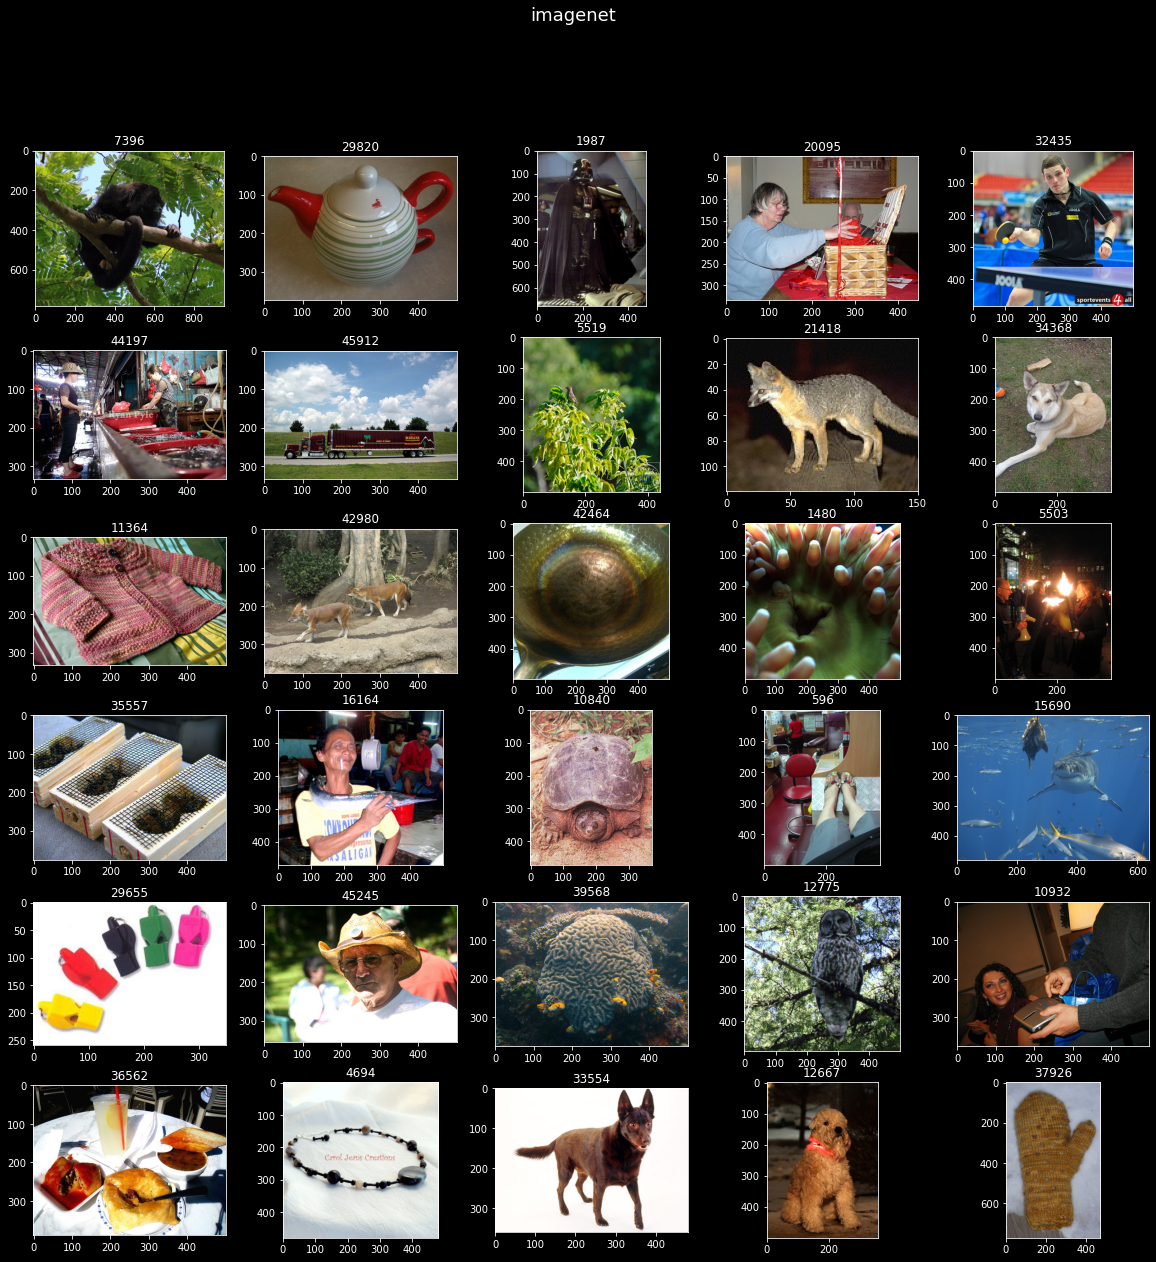

In [ ]:
plot_massive_by_label(df_imagenet, folder_path=tmp_imagenet, label="imagenet", size=30, random_state=43)

## Исходные данные

классы: 

       'alpinism', 'archery', 'arm_wrestling', 'badminton', 'basketball',
       'boating', 'boxing', 'fencing', 'football', 'golf',
       'greco-Roman_wrestling', 'gymnastics', 'handball', 'hockey',
       'horseback_riding', 'javelin-throwing', 'pole_vault', 'rugby',
       'running', 'sailing', 'sambo', 'skating', 'ski_race', 'surfing',
       'swimming', 'taekwondo', 'tennis', 'velo', 'volleyball',
       'water_polo'

In [ ]:
train_folder_path = "/kaggle/input/sports-image-classification/train"
train_table_path = "/kaggle/input/sports-image-classification/train.csv"
df = pd.read_csv(train_table_path)

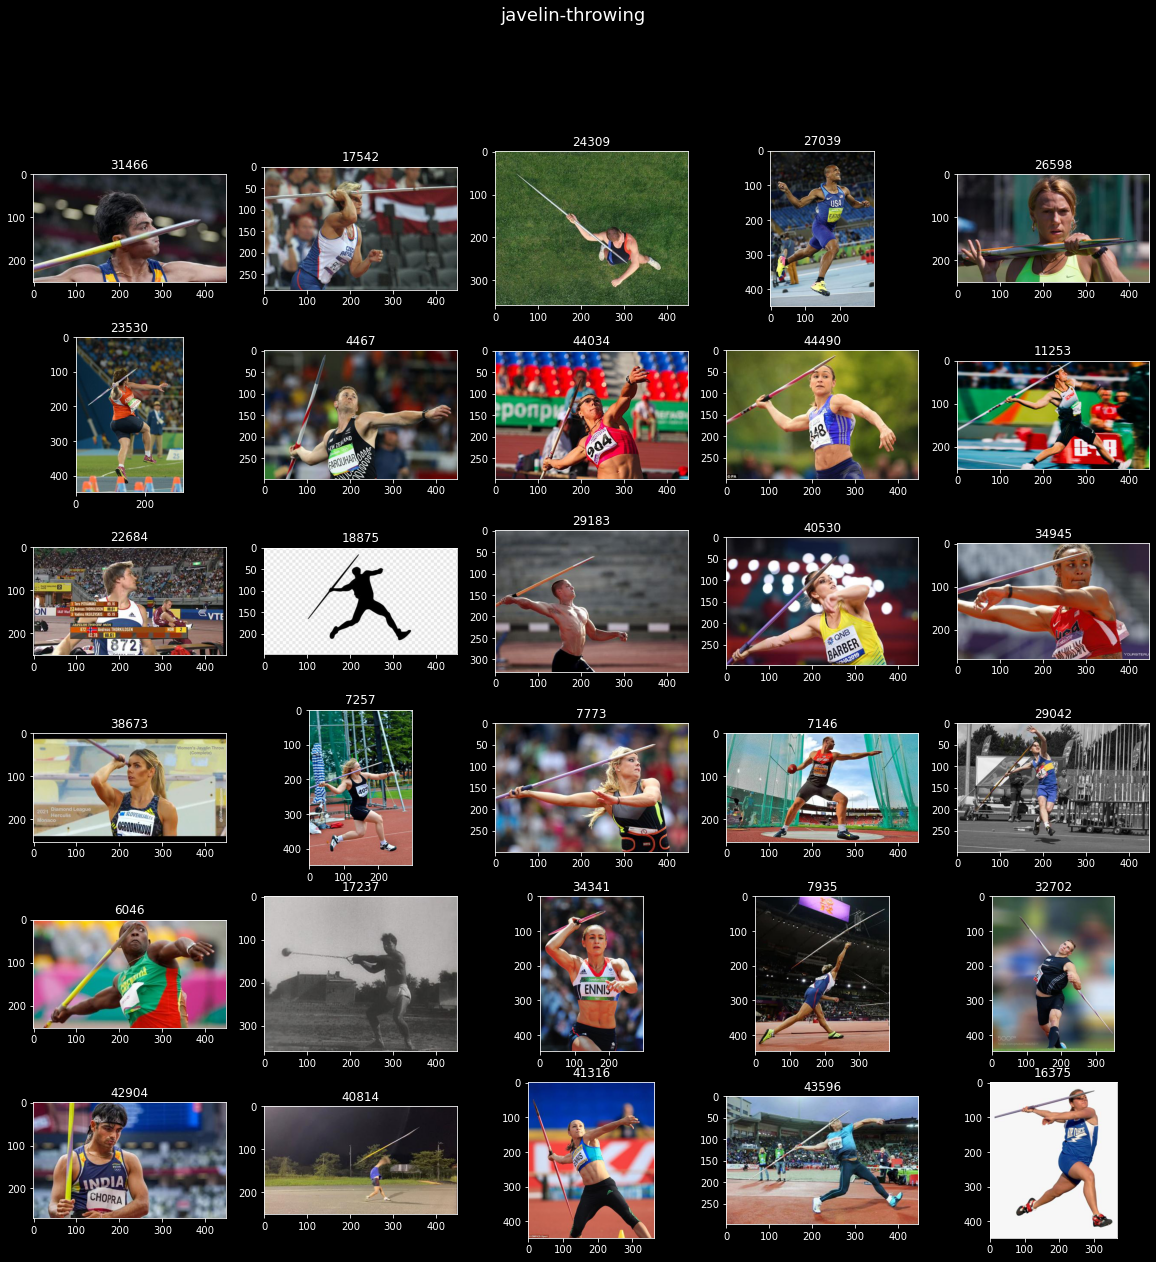

In [ ]:
plot_massive_by_label(df, folder_path=train_folder_path, label="javelin-throwing", size=30, random_state=43)

In [ ]:
sub_df_imagenet = df_imagenet.sample(n=10_000, replace=False, random_state=SEED)
sub_df_train_imagenet, sub_df_valid_imagenet = train_test_split(sub_df_imagenet, test_size=0.2, random_state=SEED, shuffle=True)
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df.label)

In [ ]:
# копирую картинки в тренировочную директорию 
imagnet_old_dir = "/kaggle/working/tmp"
input_old_dir = "/kaggle/input/sports-image-classification/train"
new_dir = "/kaggle/working/train"
os.makedirs(new_dir)

move_images(sub_df_train_imagenet.image_id.tolist(), imagnet_old_dir, new_dir)
move_images(df_train.image_id.tolist(), input_old_dir, new_dir)

  0%|          | 0/9800 [00:00<?, ?it/s]

  0%|          | 0/44465 [00:00<?, ?it/s]

In [ ]:
# копирую картинки в валидационную директорию
imagnet_old_dir = "/kaggle/working/tmp"
input_old_dir = "/kaggle/input/sports-image-classification/train"
new_dir = "/kaggle/working/valid"
os.makedirs(new_dir)


move_images(sub_df_valid_imagenet.image_id.tolist(), imagnet_old_dir, new_dir)
move_images(df_valid.image_id.tolist(), input_old_dir, new_dir)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/908 [00:00<?, ?it/s]

In [ ]:
labelEncoder = LabelEncoder().fit(df.label)
df_train["digital_label"] = labelEncoder.transform(df_train.label)
df_valid["digital_label"] = labelEncoder.transform(df_valid.label)
sub_df_train_imagenet["digital_label"] = 30
sub_df_valid_imagenet["digital_label"] = 30

train_dir_path = "/kaggle/working/train"
valid_dir_path = "/kaggle/working/valid"

train_dataset          = SportDataset(df_train, train_dir_path, transforms)
valid_dataset          = SportDataset(df_valid, valid_dir_path, transforms)
train_imagenet_dataset = SportDataset(sub_df_train_imagenet, train_dir_path, transforms)
valid_imagenet_dataset = SportDataset(sub_df_valid_imagenet, valid_dir_path, transforms)

train_loader          = DataLoader(train_dataset,          batch_size=32, shuffle=False, drop_last=False)
valid_loader          = DataLoader(valid_dataset,          batch_size=32, shuffle=False, drop_last=False)
train_imagenet_loader = DataLoader(train_imagenet_dataset, batch_size=32, shuffle=False, drop_last=False)
valid_imagenet_loader = DataLoader(valid_imagenet_dataset, batch_size=32, shuffle=False, drop_last=False)

Рассчитываю ембединги

In [ ]:
embModel = Model(embeddings, encoder, pooler).to(device)
X_train,          y_train          = get_embs(embModel, train_loader)
X_valid,          y_valid          = get_embs(embModel, valid_loader)
X_train_imagenet, y_train_imagenet = get_embs(embModel, train_imagenet_loader)
X_valid_imagenet, y_valid_imagenet = get_embs(embModel, valid_imagenet_loader)

  0%|          | 0/1390 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/307 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

## Подбор классификатора

### Исходные данные

In [ ]:
train_dataset = EmbeddingsDataset(X_train, y_train)
valid_dataset = EmbeddingsDataset(X_valid, y_valid)
train_loader  = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)
valid_loader  = DataLoader(valid_dataset, batch_size=128, shuffle=False, drop_last=False)

classifier = Classifier(emb_size=1024, dropout=0.4, n_class=30).to(device)

classifier.device = device

# optimizer
optimizer_cfg = {"lr": 1e-4, "betas":(0.9, 0.999),  "eps": 1e-8, "weight_decay": 3e-5}
optimizer = torch.optim.Adam(classifier.parameters(), **optimizer_cfg)
# criterion
criterion = nn.CrossEntropyLoss(reduction='mean').to(classifier.device)

# metrics
metrics = init_metrics()
logger = init_logger()

In [ ]:
train_loop(classifier, train_loader, valid_loader, criterion, optimizer, 60, metrics, logger, step_logger=10, verbose=False)

  0%|          | 0/60 [00:00<?, ?it/s]

[2023-02-26 18:15] [root] [INFO] > epoch: 1
[2023-02-26 18:15] [root] [INFO] > train: loss: 0.8746, f1_score: 0.7942
[2023-02-26 18:15] [root] [INFO] > valid: loss: 0.2079, f1_score: 0.9372
[2023-02-26 18:15] [root] [INFO] > 
[2023-02-26 18:15] [root] [INFO] > epoch: 11
[2023-02-26 18:15] [root] [INFO] > train: loss: 0.1479, f1_score: 0.9590
[2023-02-26 18:15] [root] [INFO] > valid: loss: 0.1255, f1_score: 0.9648
[2023-02-26 18:15] [root] [INFO] > 
[2023-02-26 18:16] [root] [INFO] > epoch: 21
[2023-02-26 18:16] [root] [INFO] > train: loss: 0.0902, f1_score: 0.9745
[2023-02-26 18:16] [root] [INFO] > valid: loss: 0.1149, f1_score: 0.9615
[2023-02-26 18:16] [root] [INFO] > 
[2023-02-26 18:16] [root] [INFO] > epoch: 31
[2023-02-26 18:16] [root] [INFO] > train: loss: 0.0625, f1_score: 0.9814
[2023-02-26 18:16] [root] [INFO] > valid: loss: 0.1155, f1_score: 0.9626
[2023-02-26 18:16] [root] [INFO] > 
[2023-02-26 18:16] [root] [INFO] > epoch: 41
[2023-02-26 18:16] [root] [INFO] > train: loss: 

### Исходные данные + imagenet

In [ ]:
X_train_combined  = np.concatenate([X_train, X_train_imagenet])
X_valid_combined  = np.concatenate([X_valid, X_valid_imagenet])
y_train_combined  = np.concatenate([y_train, y_train_imagenet])
y_valid_combined  = np.concatenate([y_valid, y_valid_imagenet])
df_train_combined = pd.concat([df_train, sub_df_train_imagenet]).reset_index()
df_valid_combined = pd.concat([df_valid, sub_df_valid_imagenet]).reset_index()


train_combined_dataset = EmbeddingsDataset(X_train_combined, y_train_combined)
valid_combined_dataset = EmbeddingsDataset(X_valid_combined, y_valid_combined)

train_combined_loader = DataLoader(train_combined_dataset, batch_size=128, shuffle=True, drop_last=False)
valid_combined_loader = DataLoader(valid_combined_dataset, batch_size=128, shuffle=False, drop_last=False)

classifier = Classifier(emb_size=1024, dropout=0.4, n_class=31).to(device)


# optimizer
optimizer_cfg = {"lr": 1e-4, "betas":(0.9, 0.999),  "eps": 1e-8, "weight_decay": 3e-5}
optimizer = torch.optim.Adam(classifier.parameters(), **optimizer_cfg)
# criterion
criterion = nn.CrossEntropyLoss(reduction='mean').to(classifier.device)

# metrics
metrics = init_metrics()
logger = init_logger()

In [ ]:
train_loop(classifier, train_combined_loader, valid_combined_loader, criterion, optimizer, 50, metrics, logger, step_logger=10, verbose=False)

  0%|          | 0/50 [00:00<?, ?it/s]

[2023-02-26 18:16] [root] [INFO] > epoch: 1
[2023-02-26 18:16] [root] [INFO] > train: loss: 0.8524, f1_score: 0.8056
[2023-02-26 18:16] [root] [INFO] > valid: loss: 0.2297, f1_score: 0.9449
[2023-02-26 18:16] [root] [INFO] > 
[2023-02-26 18:16] [root] [INFO] > epoch: 11
[2023-02-26 18:16] [root] [INFO] > train: loss: 0.1333, f1_score: 0.9633
[2023-02-26 18:16] [root] [INFO] > valid: loss: 0.1204, f1_score: 0.9639
[2023-02-26 18:16] [root] [INFO] > 
[2023-02-26 18:17] [root] [INFO] > epoch: 21
[2023-02-26 18:17] [root] [INFO] > train: loss: 0.0803, f1_score: 0.9765
[2023-02-26 18:17] [root] [INFO] > valid: loss: 0.1134, f1_score: 0.9684
[2023-02-26 18:17] [root] [INFO] > 
[2023-02-26 18:17] [root] [INFO] > epoch: 31
[2023-02-26 18:17] [root] [INFO] > train: loss: 0.0542, f1_score: 0.9840
[2023-02-26 18:17] [root] [INFO] > valid: loss: 0.1142, f1_score: 0.9684
[2023-02-26 18:17] [root] [INFO] > 
[2023-02-26 18:17] [root] [INFO] > epoch: 41
[2023-02-26 18:17] [root] [INFO] > train: loss: 

# Поиск шумов

In [ ]:
CFG = {
    "model"       : {"emb_size": 1024, "dropout": 0.3, "n_class": 31},
    "optimizer"   : {"lr": 1e-4, "betas":(0.9, 0.999),  "eps": 1e-8, "weight_decay": 3e-5},
    "criterion"   : {"reduction": "mean"},
    "train_loader": {"batch_size": 128, "shuffle": True,  "drop_last": False},
    "valid_loader": {"batch_size": 128, "shuffle": False, "drop_last": False},
}


df_proba = important_proba(X_train_combined, y_train_combined, CFG, device, n_split=20, n_epoch=30, shuffle=True, step_logger=10)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:17] [root] [INFO] > epoch: 1
[2023-02-26 18:17] [root] [INFO] > train: loss: 0.7396, f1_score: 0.8357
[2023-02-26 18:17] [root] [INFO] > valid: loss: 0.2788, f1_score: 0.9407
[2023-02-26 18:17] [root] [INFO] > 
[2023-02-26 18:17] [root] [INFO] > epoch: 11
[2023-02-26 18:17] [root] [INFO] > train: loss: 0.0897, f1_score: 0.9754
[2023-02-26 18:17] [root] [INFO] > valid: loss: 0.1865, f1_score: 0.9580
[2023-02-26 18:17] [root] [INFO] > 
[2023-02-26 18:18] [root] [INFO] > epoch: 21
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.0429, f1_score: 0.9879
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.1925, f1_score: 0.9598
[2023-02-26 18:18] [root] [INFO] > 
[2023-02-26 18:18] [root] [INFO] > epoch: 30
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.0278, f1_score: 0.9923
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.2031, f1_score: 0.9606
[2023-02-26 18:18] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:18] [root] [INFO] > epoch: 1
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.7451, f1_score: 0.8370
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.2358, f1_score: 0.9462
[2023-02-26 18:18] [root] [INFO] > 
[2023-02-26 18:18] [root] [INFO] > epoch: 11
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.0896, f1_score: 0.9757
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.1460, f1_score: 0.9606
[2023-02-26 18:18] [root] [INFO] > 
[2023-02-26 18:18] [root] [INFO] > epoch: 21
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.0452, f1_score: 0.9877
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.1415, f1_score: 0.9643
[2023-02-26 18:18] [root] [INFO] > 
[2023-02-26 18:18] [root] [INFO] > epoch: 30
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.0261, f1_score: 0.9927
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.1518, f1_score: 0.9620
[2023-02-26 18:18] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:18] [root] [INFO] > epoch: 1
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.7366, f1_score: 0.8354
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.2651, f1_score: 0.9370
[2023-02-26 18:18] [root] [INFO] > 
[2023-02-26 18:18] [root] [INFO] > epoch: 11
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.0895, f1_score: 0.9753
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.1756, f1_score: 0.9558
[2023-02-26 18:18] [root] [INFO] > 
[2023-02-26 18:18] [root] [INFO] > epoch: 21
[2023-02-26 18:18] [root] [INFO] > train: loss: 0.0427, f1_score: 0.9881
[2023-02-26 18:18] [root] [INFO] > valid: loss: 0.1782, f1_score: 0.9547
[2023-02-26 18:18] [root] [INFO] > 
[2023-02-26 18:19] [root] [INFO] > epoch: 30
[2023-02-26 18:19] [root] [INFO] > train: loss: 0.0275, f1_score: 0.9923
[2023-02-26 18:19] [root] [INFO] > valid: loss: 0.1809, f1_score: 0.9565
[2023-02-26 18:19] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:19] [root] [INFO] > epoch: 1
[2023-02-26 18:19] [root] [INFO] > train: loss: 0.7428, f1_score: 0.8355
[2023-02-26 18:19] [root] [INFO] > valid: loss: 0.2639, f1_score: 0.9377
[2023-02-26 18:19] [root] [INFO] > 
[2023-02-26 18:19] [root] [INFO] > epoch: 11
[2023-02-26 18:19] [root] [INFO] > train: loss: 0.0901, f1_score: 0.9743
[2023-02-26 18:19] [root] [INFO] > valid: loss: 0.1624, f1_score: 0.9602
[2023-02-26 18:19] [root] [INFO] > 
[2023-02-26 18:19] [root] [INFO] > epoch: 21
[2023-02-26 18:19] [root] [INFO] > train: loss: 0.0442, f1_score: 0.9880
[2023-02-26 18:19] [root] [INFO] > valid: loss: 0.1596, f1_score: 0.9646
[2023-02-26 18:19] [root] [INFO] > 
[2023-02-26 18:19] [root] [INFO] > epoch: 30
[2023-02-26 18:19] [root] [INFO] > train: loss: 0.0273, f1_score: 0.9924
[2023-02-26 18:19] [root] [INFO] > valid: loss: 0.1629, f1_score: 0.9661
[2023-02-26 18:19] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:19] [root] [INFO] > epoch: 1
[2023-02-26 18:19] [root] [INFO] > train: loss: 0.7346, f1_score: 0.8362
[2023-02-26 18:19] [root] [INFO] > valid: loss: 0.2434, f1_score: 0.9414
[2023-02-26 18:19] [root] [INFO] > 
[2023-02-26 18:19] [root] [INFO] > epoch: 21
[2023-02-26 18:19] [root] [INFO] > train: loss: 0.0431, f1_score: 0.9881
[2023-02-26 18:19] [root] [INFO] > valid: loss: 0.1601, f1_score: 0.9591
[2023-02-26 18:19] [root] [INFO] > 
[2023-02-26 18:20] [root] [INFO] > epoch: 30
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.0275, f1_score: 0.9924
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.1666, f1_score: 0.9591
[2023-02-26 18:20] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:20] [root] [INFO] > epoch: 1
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.7065, f1_score: 0.8450
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.2723, f1_score: 0.9403
[2023-02-26 18:20] [root] [INFO] > 
[2023-02-26 18:20] [root] [INFO] > epoch: 11
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.0878, f1_score: 0.9764
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.1919, f1_score: 0.9536
[2023-02-26 18:20] [root] [INFO] > 
[2023-02-26 18:20] [root] [INFO] > epoch: 21
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.0431, f1_score: 0.9879
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.2014, f1_score: 0.9547
[2023-02-26 18:20] [root] [INFO] > 
[2023-02-26 18:20] [root] [INFO] > epoch: 30
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.0262, f1_score: 0.9929
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.2153, f1_score: 0.9536
[2023-02-26 18:20] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:20] [root] [INFO] > epoch: 1
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.7301, f1_score: 0.8390
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.2782, f1_score: 0.9392
[2023-02-26 18:20] [root] [INFO] > 
[2023-02-26 18:20] [root] [INFO] > epoch: 11
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.0884, f1_score: 0.9757
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.1799, f1_score: 0.9558
[2023-02-26 18:20] [root] [INFO] > 
[2023-02-26 18:20] [root] [INFO] > epoch: 21
[2023-02-26 18:20] [root] [INFO] > train: loss: 0.0436, f1_score: 0.9875
[2023-02-26 18:20] [root] [INFO] > valid: loss: 0.1876, f1_score: 0.9598
[2023-02-26 18:20] [root] [INFO] > 
[2023-02-26 18:21] [root] [INFO] > epoch: 30
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.0256, f1_score: 0.9932
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.2020, f1_score: 0.9587
[2023-02-26 18:21] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:21] [root] [INFO] > epoch: 1
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.7387, f1_score: 0.8365
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.2442, f1_score: 0.9473
[2023-02-26 18:21] [root] [INFO] > 
[2023-02-26 18:21] [root] [INFO] > epoch: 11
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.0917, f1_score: 0.9745
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.1510, f1_score: 0.9631
[2023-02-26 18:21] [root] [INFO] > 
[2023-02-26 18:21] [root] [INFO] > epoch: 21
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.0461, f1_score: 0.9872
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.1549, f1_score: 0.9650
[2023-02-26 18:21] [root] [INFO] > 
[2023-02-26 18:21] [root] [INFO] > epoch: 30
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.0270, f1_score: 0.9924
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.1632, f1_score: 0.9642
[2023-02-26 18:21] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:21] [root] [INFO] > epoch: 1
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.7205, f1_score: 0.8403
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.2372, f1_score: 0.9458
[2023-02-26 18:21] [root] [INFO] > 
[2023-02-26 18:21] [root] [INFO] > epoch: 11
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.0914, f1_score: 0.9743
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.1573, f1_score: 0.9609
[2023-02-26 18:21] [root] [INFO] > 
[2023-02-26 18:21] [root] [INFO] > epoch: 21
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.0449, f1_score: 0.9877
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.1671, f1_score: 0.9587
[2023-02-26 18:21] [root] [INFO] > 
[2023-02-26 18:21] [root] [INFO] > epoch: 30
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.0267, f1_score: 0.9926
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.1719, f1_score: 0.9613
[2023-02-26 18:21] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:21] [root] [INFO] > epoch: 1
[2023-02-26 18:21] [root] [INFO] > train: loss: 0.7245, f1_score: 0.8400
[2023-02-26 18:21] [root] [INFO] > valid: loss: 0.2276, f1_score: 0.9458
[2023-02-26 18:21] [root] [INFO] > 
[2023-02-26 18:22] [root] [INFO] > epoch: 11
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.0885, f1_score: 0.9758
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.1602, f1_score: 0.9591
[2023-02-26 18:22] [root] [INFO] > 
[2023-02-26 18:22] [root] [INFO] > epoch: 21
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.0422, f1_score: 0.9887
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.1693, f1_score: 0.9617
[2023-02-26 18:22] [root] [INFO] > 
[2023-02-26 18:22] [root] [INFO] > epoch: 30
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.0256, f1_score: 0.9932
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.1831, f1_score: 0.9583
[2023-02-26 18:22] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:22] [root] [INFO] > epoch: 1
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.7370, f1_score: 0.8367
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.2536, f1_score: 0.9454
[2023-02-26 18:22] [root] [INFO] > 
[2023-02-26 18:22] [root] [INFO] > epoch: 11
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.0914, f1_score: 0.9745
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.1691, f1_score: 0.9620
[2023-02-26 18:22] [root] [INFO] > 
[2023-02-26 18:22] [root] [INFO] > epoch: 21
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.0444, f1_score: 0.9872
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.1762, f1_score: 0.9613
[2023-02-26 18:22] [root] [INFO] > 
[2023-02-26 18:22] [root] [INFO] > epoch: 30
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.0269, f1_score: 0.9923
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.1842, f1_score: 0.9620
[2023-02-26 18:22] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:22] [root] [INFO] > epoch: 1
[2023-02-26 18:22] [root] [INFO] > train: loss: 0.7346, f1_score: 0.8383
[2023-02-26 18:22] [root] [INFO] > valid: loss: 0.2699, f1_score: 0.9359
[2023-02-26 18:22] [root] [INFO] > 
[2023-02-26 18:23] [root] [INFO] > epoch: 11
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.0895, f1_score: 0.9756
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.1824, f1_score: 0.9525
[2023-02-26 18:23] [root] [INFO] > 
[2023-02-26 18:23] [root] [INFO] > epoch: 21
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.0455, f1_score: 0.9873
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.1814, f1_score: 0.9550
[2023-02-26 18:23] [root] [INFO] > 
[2023-02-26 18:23] [root] [INFO] > epoch: 30
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.0267, f1_score: 0.9930
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.1954, f1_score: 0.9539
[2023-02-26 18:23] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:23] [root] [INFO] > epoch: 1
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.7343, f1_score: 0.8360
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.2719, f1_score: 0.9373
[2023-02-26 18:23] [root] [INFO] > 
[2023-02-26 18:23] [root] [INFO] > epoch: 11
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.0893, f1_score: 0.9749
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.1567, f1_score: 0.9576
[2023-02-26 18:23] [root] [INFO] > 
[2023-02-26 18:23] [root] [INFO] > epoch: 21
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.0446, f1_score: 0.9877
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.1591, f1_score: 0.9569
[2023-02-26 18:23] [root] [INFO] > 
[2023-02-26 18:23] [root] [INFO] > epoch: 30
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.0280, f1_score: 0.9923
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.1677, f1_score: 0.9569
[2023-02-26 18:23] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:23] [root] [INFO] > epoch: 1
[2023-02-26 18:23] [root] [INFO] > train: loss: 0.7322, f1_score: 0.8389
[2023-02-26 18:23] [root] [INFO] > valid: loss: 0.2371, f1_score: 0.9454
[2023-02-26 18:23] [root] [INFO] > 
[2023-02-26 18:24] [root] [INFO] > epoch: 11
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.0891, f1_score: 0.9756
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.1474, f1_score: 0.9650
[2023-02-26 18:24] [root] [INFO] > 
[2023-02-26 18:24] [root] [INFO] > epoch: 21
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.0446, f1_score: 0.9876
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.1499, f1_score: 0.9650
[2023-02-26 18:24] [root] [INFO] > 
[2023-02-26 18:24] [root] [INFO] > epoch: 30
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.0276, f1_score: 0.9924
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.1550, f1_score: 0.9650
[2023-02-26 18:24] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:24] [root] [INFO] > epoch: 1
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.7618, f1_score: 0.8309
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.2407, f1_score: 0.9447
[2023-02-26 18:24] [root] [INFO] > 
[2023-02-26 18:24] [root] [INFO] > epoch: 11
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.0915, f1_score: 0.9749
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.1409, f1_score: 0.9587
[2023-02-26 18:24] [root] [INFO] > 
[2023-02-26 18:24] [root] [INFO] > epoch: 21
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.0442, f1_score: 0.9879
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.1424, f1_score: 0.9606
[2023-02-26 18:24] [root] [INFO] > 
[2023-02-26 18:24] [root] [INFO] > epoch: 30
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.0271, f1_score: 0.9927
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.1460, f1_score: 0.9613
[2023-02-26 18:24] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:24] [root] [INFO] > epoch: 1
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.7372, f1_score: 0.8367
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.2557, f1_score: 0.9388
[2023-02-26 18:24] [root] [INFO] > 
[2023-02-26 18:24] [root] [INFO] > epoch: 11
[2023-02-26 18:24] [root] [INFO] > train: loss: 0.0897, f1_score: 0.9747
[2023-02-26 18:24] [root] [INFO] > valid: loss: 0.1750, f1_score: 0.9565
[2023-02-26 18:24] [root] [INFO] > 
[2023-02-26 18:25] [root] [INFO] > epoch: 21
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.0450, f1_score: 0.9873
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.1811, f1_score: 0.9569
[2023-02-26 18:25] [root] [INFO] > 
[2023-02-26 18:25] [root] [INFO] > epoch: 30
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.0262, f1_score: 0.9933
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.1921, f1_score: 0.9558
[2023-02-26 18:25] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:25] [root] [INFO] > epoch: 1
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.7242, f1_score: 0.8404
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.2212, f1_score: 0.9477
[2023-02-26 18:25] [root] [INFO] > 
[2023-02-26 18:25] [root] [INFO] > epoch: 11
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.0885, f1_score: 0.9759
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.1234, f1_score: 0.9668
[2023-02-26 18:25] [root] [INFO] > 
[2023-02-26 18:25] [root] [INFO] > epoch: 21
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.0455, f1_score: 0.9875
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.1260, f1_score: 0.9676
[2023-02-26 18:25] [root] [INFO] > 
[2023-02-26 18:25] [root] [INFO] > epoch: 30
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.0277, f1_score: 0.9924
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.1366, f1_score: 0.9650
[2023-02-26 18:25] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:25] [root] [INFO] > epoch: 1
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.7308, f1_score: 0.8372
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.2244, f1_score: 0.9528
[2023-02-26 18:25] [root] [INFO] > 
[2023-02-26 18:25] [root] [INFO] > epoch: 11
[2023-02-26 18:25] [root] [INFO] > train: loss: 0.0915, f1_score: 0.9743
[2023-02-26 18:25] [root] [INFO] > valid: loss: 0.1424, f1_score: 0.9642
[2023-02-26 18:25] [root] [INFO] > 
[2023-02-26 18:26] [root] [INFO] > epoch: 21
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.0454, f1_score: 0.9872
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.1449, f1_score: 0.9661
[2023-02-26 18:26] [root] [INFO] > 
[2023-02-26 18:26] [root] [INFO] > epoch: 30
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.0264, f1_score: 0.9922
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.1474, f1_score: 0.9676
[2023-02-26 18:26] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:26] [root] [INFO] > epoch: 1
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.7130, f1_score: 0.8418
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.2676, f1_score: 0.9396
[2023-02-26 18:26] [root] [INFO] > 
[2023-02-26 18:26] [root] [INFO] > epoch: 11
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.0867, f1_score: 0.9760
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.1839, f1_score: 0.9550
[2023-02-26 18:26] [root] [INFO] > 
[2023-02-26 18:26] [root] [INFO] > epoch: 21
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.0423, f1_score: 0.9882
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.1916, f1_score: 0.9569
[2023-02-26 18:26] [root] [INFO] > 
[2023-02-26 18:26] [root] [INFO] > epoch: 30
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.0269, f1_score: 0.9922
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.1941, f1_score: 0.9565
[2023-02-26 18:26] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

[2023-02-26 18:26] [root] [INFO] > epoch: 1
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.7523, f1_score: 0.8345
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.2358, f1_score: 0.9473
[2023-02-26 18:26] [root] [INFO] > 
[2023-02-26 18:26] [root] [INFO] > epoch: 11
[2023-02-26 18:26] [root] [INFO] > train: loss: 0.0891, f1_score: 0.9749
[2023-02-26 18:26] [root] [INFO] > valid: loss: 0.1456, f1_score: 0.9635
[2023-02-26 18:26] [root] [INFO] > 
[2023-02-26 18:27] [root] [INFO] > epoch: 21
[2023-02-26 18:27] [root] [INFO] > train: loss: 0.0441, f1_score: 0.9878
[2023-02-26 18:27] [root] [INFO] > valid: loss: 0.1497, f1_score: 0.9639
[2023-02-26 18:27] [root] [INFO] > 
[2023-02-26 18:27] [root] [INFO] > epoch: 30
[2023-02-26 18:27] [root] [INFO] > train: loss: 0.0264, f1_score: 0.9928
[2023-02-26 18:27] [root] [INFO] > valid: loss: 0.1548, f1_score: 0.9639
[2023-02-26 18:27] [root] [INFO] > 


  0%|          | 0/22 [00:00<?, ?it/s]

Датафрейм для анализа. Джойню исходный с датафреймом содержащим вероятности, с которыми модель определяет принадлежность к одной из групп

In [ ]:
columns = ["pred_digital_label", "true_proba", "max_proba",	"imagenet_proba"]
df_analyze = pd.concat([df_train_combined, df_proba[columns]], axis=1)
mask = df_analyze.pred_digital_label.values != 30
df_analyze.loc[mask, "pred_label"] = labelEncoder.inverse_transform(df_analyze.pred_digital_label[mask])
df_analyze.loc[~mask, "pred_label"] = "imagenet"
columns = ["image_id", "label", "pred_label", "digital_label", "pred_digital_label", "true_proba", "max_proba", "imagenet_proba"]
df_analyze = df_analyze[columns] 

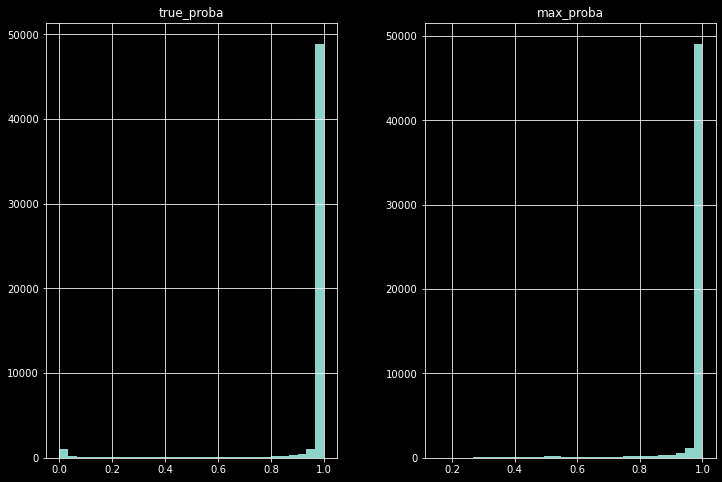

In [ ]:
col = ["true_proba", "max_proba"]
df_analyze[col].hist(figsize=(12, 8), bins=30)
None

In [ ]:
df_analyze.head()

image_id                  label  \
0  5c290922-c193-4c47-a1e3-a441cb43a73f.jpeg          arm_wrestling   
1  a1eef13c-9706-4c1f-acaf-ae3f9afd4e45.jpeg                   velo   
2  785b4fd3-c93c-4453-b766-96710de1165f.jpeg  greco-Roman_wrestling   
3  ab963331-cf2e-4792-914e-b56d20c0a638.jpeg       horseback_riding   
4  7d7ddc69-8655-4813-98e7-07c448b1902a.jpeg                archery   

              pred_label  digital_label  pred_digital_label  true_proba  \
0          arm_wrestling              2                   2    0.999994   
1                   velo             27                  27    0.996046   
2  greco-Roman_wrestling             10                  10    0.993728   
3       horseback_riding             14                  14    0.999999   
4                archery              1                   1    1.000000   

   max_proba  imagenet_proba  
0   0.999994    4.814614e-09  
1   0.996046    1.940267e-04  
2   0.993728    5.262509e-09  
3   0.999999    1.218747e-06  
4   1.000000    5.224551e-09

Маски для переразметки

In [ ]:
mask_swap = (df_analyze.true_proba.values < 0.1) * (df_analyze.max_proba.values > 0.9) * (df_analyze.pred_digital_label.values != 30)
mask_to_imagenet = (df_analyze.digital_label.values != 30) * (df_analyze.imagenet_proba.values > 0.7)
mask_from_imagenet = (df_analyze.digital_label.values == 30) * (df_analyze.pred_digital_label.values != 30) * (df_analyze.max_proba.values > 0.7)

In [ ]:
df_swap = df_analyze.iloc[mask_swap, :].sort_values(by="true_proba").reset_index(drop=True)
df_to_imagenet = df_analyze.iloc[mask_to_imagenet, :].sort_values(by="true_proba").reset_index(drop=True)
df_from_imagenet = df_analyze.iloc[mask_from_imagenet, :].sort_values(by="true_proba").reset_index(drop=True) 

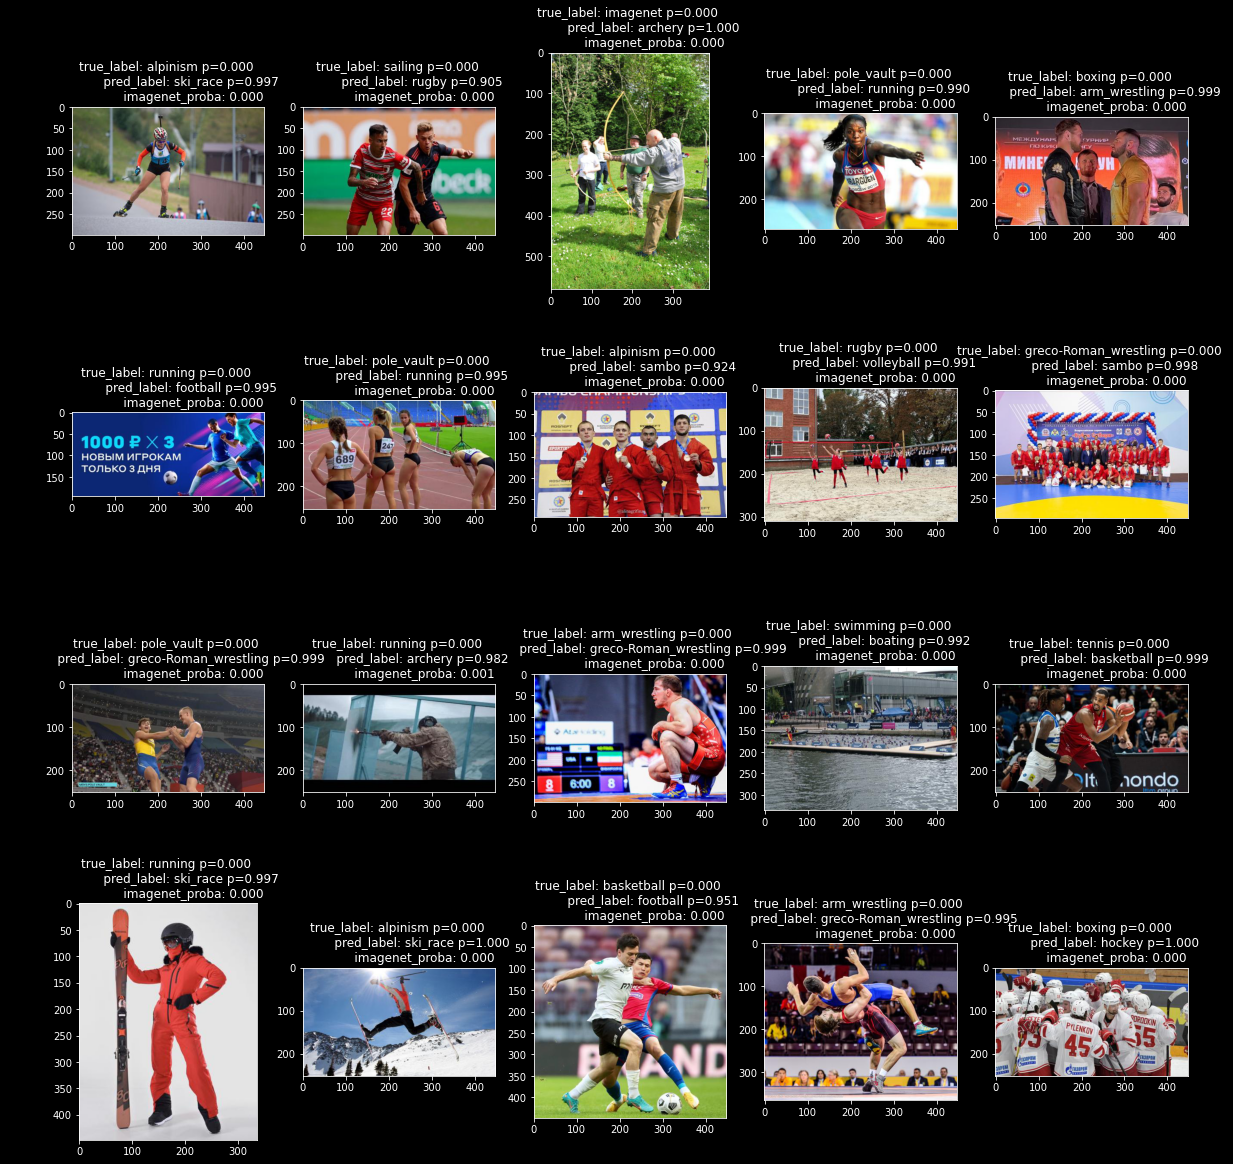

In [ ]:
plot_cross_probabilities(df_swap.iloc[200:, :])

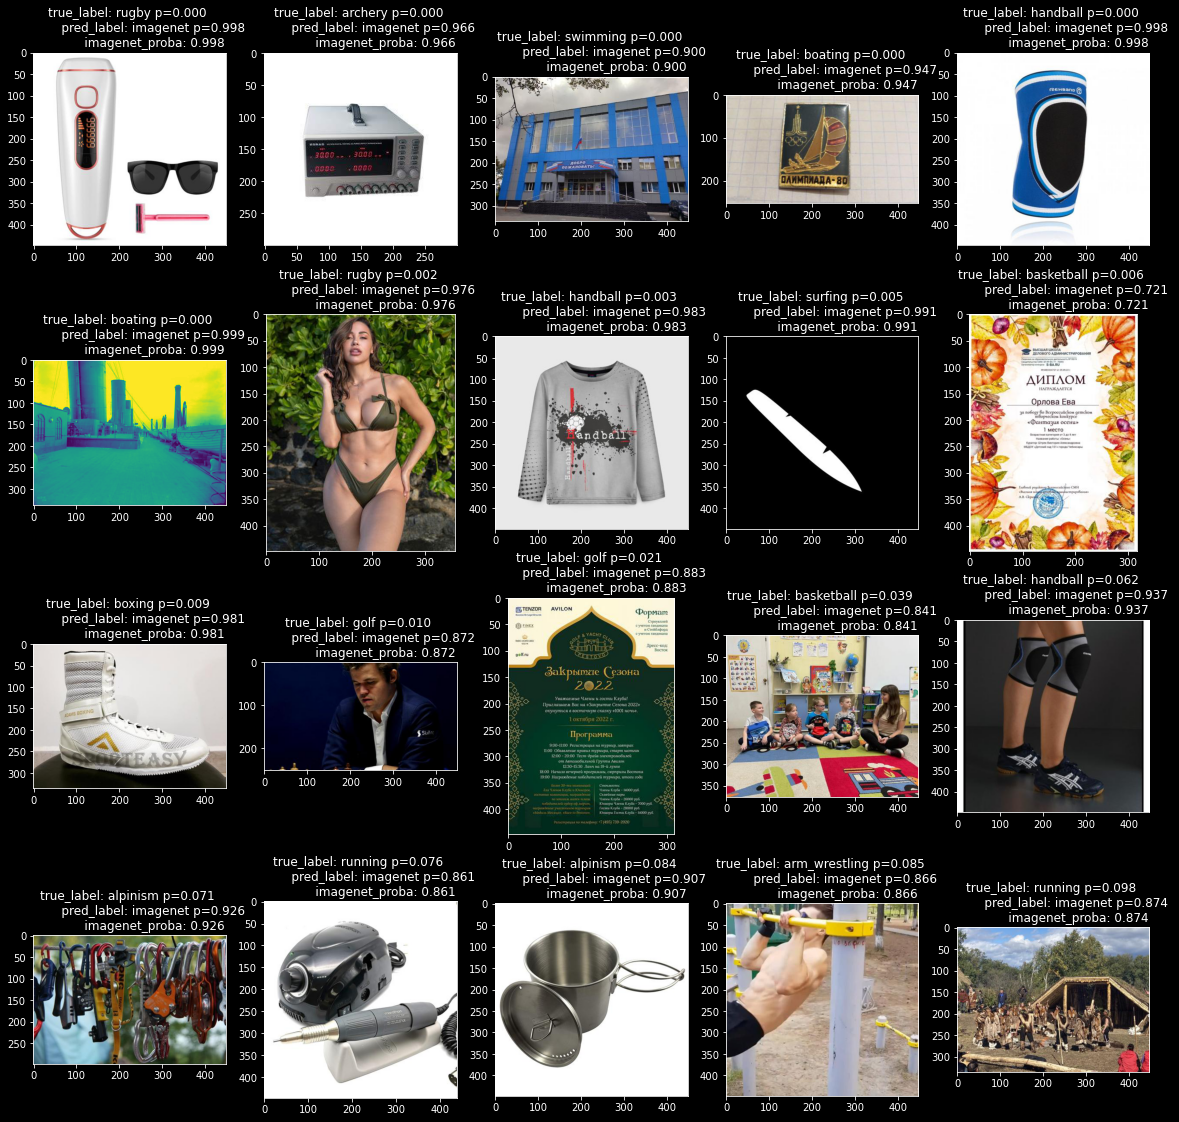

In [ ]:
plot_cross_probabilities(df_to_imagenet)

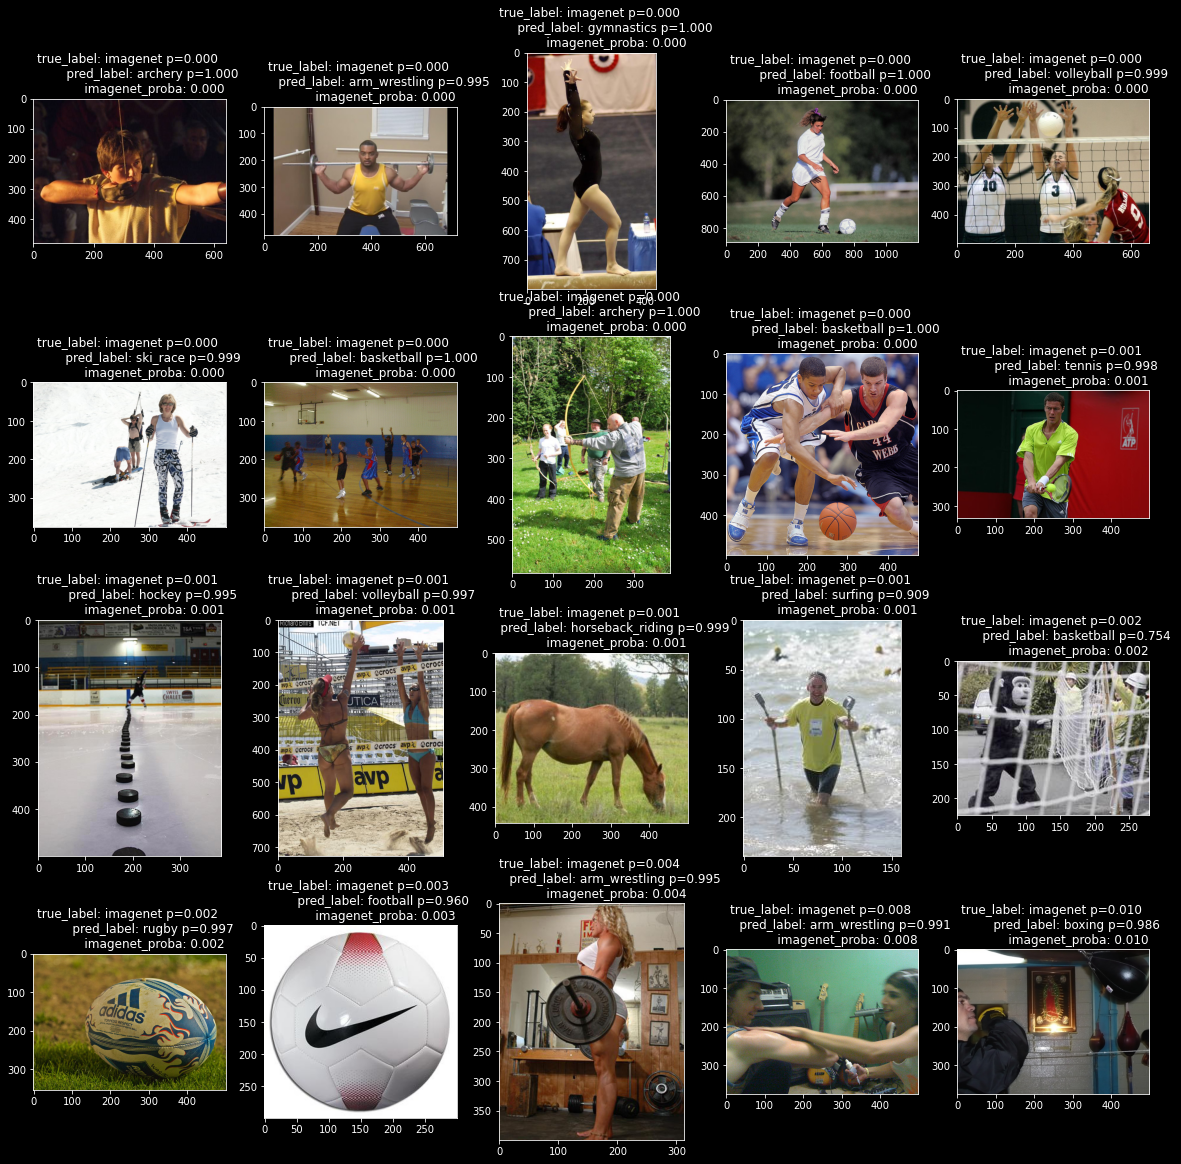

In [ ]:
plot_cross_probabilities(df_from_imagenet)

In [ ]:
df_train

index                                   image_id  \
0      32805  5c290922-c193-4c47-a1e3-a441cb43a73f.jpeg   
1      28428  a1eef13c-9706-4c1f-acaf-ae3f9afd4e45.jpeg   
2       3073  785b4fd3-c93c-4453-b766-96710de1165f.jpeg   
3       5405  ab963331-cf2e-4792-914e-b56d20c0a638.jpeg   
4      24470  7d7ddc69-8655-4813-98e7-07c448b1902a.jpeg   
...      ...                                        ...   
44516  38261               ILSVRC2012_val_00007984.JPEG   
44517  13606               ILSVRC2012_val_00014691.JPEG   
44518  36557               ILSVRC2012_val_00040578.JPEG   
44519  45251               ILSVRC2012_val_00047680.JPEG   
44520  24081               ILSVRC2012_val_00023704.JPEG   

                       label  digital_label  
0              arm_wrestling              2  
1                       velo             27  
2      greco-Roman_wrestling             10  
3           horseback_riding             14  
4                    archery              1  
...                      ...            ...  
44516               imagenet             24  
44517               imagenet             19  
44518               imagenet              6  
44519               imagenet             28  
44520               imagenet              2  

[44521 rows x 4 columns]

In [ ]:
df_train_combined

index                                   image_id  \
0      32805  5c290922-c193-4c47-a1e3-a441cb43a73f.jpeg   
1      28428  a1eef13c-9706-4c1f-acaf-ae3f9afd4e45.jpeg   
2       3073  785b4fd3-c93c-4453-b766-96710de1165f.jpeg   
3       5405  ab963331-cf2e-4792-914e-b56d20c0a638.jpeg   
4      24470  7d7ddc69-8655-4813-98e7-07c448b1902a.jpeg   
...      ...                                        ...   
54260  49939               ILSVRC2012_val_00035953.JPEG   
54261   6420               ILSVRC2012_val_00014961.JPEG   
54262  48421               ILSVRC2012_val_00017548.JPEG   
54263  26037               ILSVRC2012_val_00044069.JPEG   
54264  31247               ILSVRC2012_val_00046077.JPEG   

                       label  digital_label  
0              arm_wrestling              2  
1                       velo             27  
2      greco-Roman_wrestling             10  
3           horseback_riding             14  
4                    archery              1  
...                      ...            ...  
54260               imagenet             30  
54261               imagenet             30  
54262               imagenet             30  
54263               imagenet             30  
54264               imagenet             30  

[54265 rows x 4 columns]

In [ ]:
y_train_combined[mask_swap] = df_analyze.pred_digital_label.values[mask_swap] # заменяю метки неправильной разметки исходных картинок

y_train_combined[mask_from_imagenet] = df_analyze.pred_digital_label.values[mask_from_imagenet]
df_train_combined["digital_label"] = y_train_combined
y_train_combined[mask_to_imagenet] = 30

mask_data = y_train_combined != 30

df_train = df_train_combined.iloc[mask_data, :].reset_index(drop=True)
df_train["label"] = labelEncoder.inverse_transform(df_train["digital_label"].values)


In [ ]:
y_train = y_train_combined[mask_data]
X_train = X_train_combined[mask_data]

train_dataset = EmbeddingsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)

classifier = Classifier(emb_size=1024, dropout=0.4, n_class=30).to(device)

# optimizer
optimizer_cfg = {"lr": 1e-4, "betas":(0.9, 0.999),  "eps": 1e-8, "weight_decay": 3e-5}
optimizer = torch.optim.Adam(classifier.parameters(), **optimizer_cfg)
# criterion
criterion = nn.CrossEntropyLoss(reduction='mean').to(classifier.device)

# metrics
metrics = init_metrics()
logger = init_logger()

In [ ]:
train_loop(classifier, train_loader, valid_loader, criterion, optimizer, 40, metrics, logger, step_logger=10, verbose=False)

  0%|          | 0/40 [00:00<?, ?it/s]

[2023-02-26 18:34] [root] [INFO] > epoch: 1
[2023-02-26 18:34] [root] [INFO] > train: loss: 0.8094, f1_score: 0.8067
[2023-02-26 18:34] [root] [INFO] > valid: loss: 0.2145, f1_score: 0.9427
[2023-02-26 18:34] [root] [INFO] > 
[2023-02-26 18:34] [root] [INFO] > epoch: 2
[2023-02-26 18:34] [root] [INFO] > train: loss: 0.2633, f1_score: 0.9316
[2023-02-26 18:34] [root] [INFO] > valid: loss: 0.1895, f1_score: 0.9438
[2023-02-26 18:34] [root] [INFO] > 
[2023-02-26 18:34] [root] [INFO] > epoch: 3
[2023-02-26 18:34] [root] [INFO] > train: loss: 0.2115, f1_score: 0.9439
[2023-02-26 18:34] [root] [INFO] > valid: loss: 0.1734, f1_score: 0.9526
[2023-02-26 18:34] [root] [INFO] > 
[2023-02-26 18:34] [root] [INFO] > epoch: 4
[2023-02-26 18:34] [root] [INFO] > train: loss: 0.1793, f1_score: 0.9496
[2023-02-26 18:34] [root] [INFO] > valid: loss: 0.1658, f1_score: 0.9526
[2023-02-26 18:34] [root] [INFO] > 
[2023-02-26 18:34] [root] [INFO] > epoch: 5
[2023-02-26 18:34] [root] [INFO] > train: loss: 0.15

# Использование тестового датасета

In [ ]:
labels_path_test = "/kaggle/input/sports-image-classification/test.csv"
img_path_test = "/kaggle/input/sports-image-classification/test"

df_test = pd.read_csv(labels_path_test)

test_dataset = SportDataset(df_test, img_path_test, transforms, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=False)

X_test, y_test = get_embs(embModel, test_dataloader)

  0%|          | 0/608 [00:00<?, ?it/s]

In [ ]:
test_emb_dataset = EmbeddingsDataset(X_test, y_test)
test_emb_dataloader = DataLoader(test_emb_dataset, batch_size=128, shuffle=False, drop_last=False)
y_proba = predict(classifier, test_emb_dataloader, probabilities=True)

  0%|          | 0/152 [00:00<?, ?it/s]

уверенно классифицируемые картинки добавляю в тренировочный датасет

In [ ]:
max_proba, y_test_pred = y_proba.max(dim=1)
mask = (max_proba > 0.95).numpy()   

df_test_train = df_test.iloc[mask, :].reset_index(drop=True)
df_test_train["digital_label"] = y_test_pred[mask]
df_test_train["label"] = labelEncoder.inverse_transform(y_test_pred[mask])

X_train = np.concatenate([X_train, X_test[mask, :]])
y_train = np.concatenate([y_train, y_test_pred[mask]])
df_train = pd.concat([df_train, df_test_train])


In [ ]:
input_old_dir = "/kaggle/input/sports-image-classification/test"
new_dir = "/kaggle/working/train"
move_images(df_test_train.image_id.tolist(), input_old_dir, new_dir)

  0%|          | 0/18162 [00:00<?, ?it/s]

In [ ]:
train_dataset = EmbeddingsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)


classifier = Classifier(emb_size=1024, dropout=0.4, n_class=30).to(device)

# optimizer
optimizer_cfg = {"lr": 1e-4, "betas":(0.9, 0.999),  "eps": 1e-8, "weight_decay": 3e-5}
optimizer = torch.optim.Adam(classifier.parameters(), **optimizer_cfg)

# criterion
criterion = nn.CrossEntropyLoss(reduction='mean').to(classifier.device)

# metrics
metrics = init_metrics()
logger = init_logger()

In [ ]:
train_loop(classifier, train_loader, valid_loader, criterion, optimizer, 60, metrics, logger, step_logger=20, verbose=False)

  0%|          | 0/60 [00:00<?, ?it/s]

[2023-02-26 18:48] [root] [INFO] > epoch: 1
[2023-02-26 18:48] [root] [INFO] > train: loss: 0.6126, f1_score: 0.8533
[2023-02-26 18:48] [root] [INFO] > valid: loss: 0.2021, f1_score: 0.9438
[2023-02-26 18:48] [root] [INFO] > 
[2023-02-26 18:49] [root] [INFO] > epoch: 21
[2023-02-26 18:49] [root] [INFO] > train: loss: 0.0319, f1_score: 0.9901
[2023-02-26 18:49] [root] [INFO] > valid: loss: 0.1466, f1_score: 0.9604
[2023-02-26 18:49] [root] [INFO] > 
[2023-02-26 18:49] [root] [INFO] > epoch: 41
[2023-02-26 18:49] [root] [INFO] > train: loss: 0.0140, f1_score: 0.9957
[2023-02-26 18:49] [root] [INFO] > valid: loss: 0.1624, f1_score: 0.9615
[2023-02-26 18:49] [root] [INFO] > 
[2023-02-26 18:49] [root] [INFO] > epoch: 60
[2023-02-26 18:49] [root] [INFO] > train: loss: 0.0096, f1_score: 0.9970
[2023-02-26 18:49] [root] [INFO] > valid: loss: 0.1837, f1_score: 0.9615
[2023-02-26 18:49] [root] [INFO] > 


### копирую хорошо различимые тестовые данные

Делаю 2 вида аугментации, и добавляю к исходным данным

In [ ]:
compose1 = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=1),
    torchvision.transforms.RandomCrop(224, pad_if_needed=True),
])
compose2 = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0),
    torchvision.transforms.RandomCrop(224, pad_if_needed=True),
])

train_dir_path = "/kaggle/working/train"

embModel = Model(embeddings, encoder, pooler).to(device)

train_dataset1 = SportDataset(df_train, train_dir_path, transforms, compose1)
train_dataset2 = SportDataset(df_train, train_dir_path, transforms, compose2)
train_loader1 = DataLoader(train_dataset1, batch_size=32, shuffle=False, drop_last=False)
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=False, drop_last=False)

X_train_aug1, y_train_aug1 = get_embs(embModel, train_loader1)
X_train_aug2, y_train_aug2 = get_embs(embModel, train_loader2)

  0%|          | 0/1959 [00:00<?, ?it/s]

  0%|          | 0/1959 [00:00<?, ?it/s]

In [ ]:
X_train = np.concatenate([X_train, X_train_aug1, X_train_aug1])
y_train = np.concatenate([y_train, y_train_aug1, y_train_aug2])

train_dataset = EmbeddingsDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)

classifier = Classifier(emb_size=1024, dropout=0.4, n_class=30).to(device)

# optimizer
optimizer_cfg = {"lr": 1e-4, "betas":(0.9, 0.999),  "eps": 1e-8, "weight_decay": 3e-5}
optimizer = torch.optim.Adam(classifier.parameters(), **optimizer_cfg)

# criterion
criterion = nn.CrossEntropyLoss(reduction='mean').to(classifier.device)

# metrics
metrics = init_metrics()
logger = init_logger()

In [ ]:
train_loop(classifier, train_loader, valid_loader, criterion, optimizer, 70, metrics, logger, step_logger=10, verbose=False)

  0%|          | 0/70 [00:00<?, ?it/s]

[2023-02-26 19:45] [root] [INFO] > epoch: 1
[2023-02-26 19:45] [root] [INFO] > train: loss: 0.3622, f1_score: 0.9093
[2023-02-26 19:45] [root] [INFO] > valid: loss: 0.1732, f1_score: 0.9581
[2023-02-26 19:45] [root] [INFO] > 
[2023-02-26 19:46] [root] [INFO] > epoch: 11
[2023-02-26 19:46] [root] [INFO] > train: loss: 0.0398, f1_score: 0.9873
[2023-02-26 19:46] [root] [INFO] > valid: loss: 0.1587, f1_score: 0.9626
[2023-02-26 19:46] [root] [INFO] > 
[2023-02-26 19:47] [root] [INFO] > epoch: 21
[2023-02-26 19:47] [root] [INFO] > train: loss: 0.0190, f1_score: 0.9939
[2023-02-26 19:47] [root] [INFO] > valid: loss: 0.1772, f1_score: 0.9659
[2023-02-26 19:47] [root] [INFO] > 
[2023-02-26 19:48] [root] [INFO] > epoch: 31
[2023-02-26 19:48] [root] [INFO] > train: loss: 0.0120, f1_score: 0.9960
[2023-02-26 19:48] [root] [INFO] > valid: loss: 0.1810, f1_score: 0.9626
[2023-02-26 19:48] [root] [INFO] > 
[2023-02-26 19:49] [root] [INFO] > epoch: 41
[2023-02-26 19:49] [root] [INFO] > train: loss: 

# Дообучение енкодера

In [ ]:
compose = trans.Compose([
    trans.RandomHorizontalFlip(p=0.5),
    trans.RandomCrop(224, pad_if_needed=True),
])

train_dir_path = "/kaggle/working/train"
valid_dir_path = "/kaggle/working/valid"
train_dataset = SportDataset(final_df, train_dir_path, transforms, compose)
valid_dataset = SportDataset(df_valid, valid_dir_path, transforms)
train_loader  = DataLoader(train_dataset,  batch_size=64, shuffle=False, drop_last=False)
valid_loader  = DataLoader(valid_dataset,  batch_size=64, shuffle=False, drop_last=False)


In [ ]:
class LayerScheduller:
    
    def __init__(self, layers: List[torch.nn.Module]):
        self.stack = layers
        
    def step(self) -> None:
        if self.stack:
            layer = self.stack.pop()
            for param in layer.parameters():
                param.requires_grad = True

def zero_grad(module) -> None:
    for param in module.parameters():
        param.requires_grad = False
                
def get_group(params):
    no_decay = ['bias', 'LayerNorm.weight', "LayerNorm.bias"]
    group = [
        {"params": [p for n, p in params.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": 3e-5, "lr": 3e-5},
        {"params": [p for n, p in params.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0, "lr": 3e-5}
    ]
    return group


    
zero_grad(embeddings)
zero_grad(encoder)
zero_grad(pooler)
model = Model(embeddings, encoder, pooler, classifier).to(device)
stack_layers = [embeddings] + [layer for layer in encoder.layer] + [pooler]
layer_scheduller = LayerScheduller(stack_layers)

optimizer.add_param_group(get_group(embeddings)[0])
optimizer.add_param_group(get_group(embeddings)[1])
optimizer.add_param_group(get_group(encoder)[0])
optimizer.add_param_group(get_group(encoder)[1])
optimizer.add_param_group(get_group(pooler)[0])
optimizer.add_param_group(get_group(pooler)[1])

In [ ]:
layer_scheduller.step() # layernorm
layer_scheduller.step() # -1 блок бейта
train_loop(model, train_loader, valid_loader, criterion, optimizer, 1, metrics, logger, step_logger=1,  verbose=True)

In [ ]:
train_loop(model, train_loader, valid_loader, criterion, optimizer, 1, metrics, logger, step_logger=1,  verbose=True)

In [ ]:
train_loop(model, train_loader, valid_loader, criterion, optimizer, 1, metrics, logger, step_logger=1,  verbose=True)

In [ ]:
train_loop(model, train_loader, valid_loader, criterion, optimizer, 2, metrics, logger, step_logger=1,  verbose=True)

# Predict

In [ ]:
y_pred = predict(classifier, test_emb_dataloader, probabilities=False)
labels = labelEncoder.inverse_transform(y_pred)
df_test["label"] = labels
df_test.to_csv("sub.csv", index=False)

  0%|          | 0/152 [00:00<?, ?it/s]